In [1]:
import cv2
import itertools
import pathlib
import warnings
import os
import random
import time
import gc
import keras
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import matplotlib.image as img
from IPython.display import Markdown, display
from PIL import Image
from random import randint
warnings.filterwarnings('ignore')
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow import keras
from keras import Sequential
from keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.utils.vis_utils import plot_model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout,SeparableConv2D, Activation, BatchNormalization, Flatten, GlobalAveragePooling2D, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG



In [2]:
np.random.seed(0)

def printout(string):   
    display(Markdown(string))

def fetch_images(folder,only_path = False, label = ""):
    if only_path == False:
        images = []
        for filename in os.listdir(folder):
            img = plt.imread(os.path.join(folder,filename))
            if img is not None:
                images.append(img)
        return images
    else:
        path = []
        for filename in os.listdir(folder):
            image_path = os.path.join(folder,filename)
            if image_path is not None:
                path.append([label,image_path])
        return path

In [3]:
images = []
d1 = "/kaggle/input/fruit-recognition/"
for f1 in os.listdir(d1):
    if "png" in os.listdir(d1+f1)[0]:
        images += fetch_images(d1+f1,True,label = f1)
    else: 
        for d in os.listdir(d1+f1):
            images += fetch_images(d1+f1+"/"+d,True,label = f1)
            
dataframe = pd.DataFrame(images, columns = ["fruit", "path"])

In [4]:
from sklearn.utils import shuffle
dataframe = shuffle(dataframe, random_state = 0)
dataframe = dataframe.reset_index(drop=True)

In [5]:
fruit_names = sorted(dataframe.fruit.unique())
map_names = dict(zip(fruit_names, [t for t in range(len(fruit_names))]))
dataframe["label"] = dataframe["fruit"].map(map_names)
# print(map_names)

dataframe

,fruit,path,label
0,Pomegranate,/kaggle/input/fruit-recognition/Pomegranate/Po...,12
1,Pomegranate,/kaggle/input/fruit-recognition/Pomegranate/Po...,12
2,Kiwi,/kaggle/input/fruit-recognition/Kiwi/kiwi A/Ki...,4
3,Mango,/kaggle/input/fruit-recognition/Mango/Mango003...,5
4,Guava,/kaggle/input/fruit-recognition/Guava/Guava to...,3
...,...,...,...
70544,Guava,/kaggle/input/fruit-recognition/Guava/guava B/...,3
70545,Kiwi,/kaggle/input/fruit-recognition/Kiwi/Total Num...,4
70546,Kiwi,/kaggle/input/fruit-recognition/Kiwi/kiwi A/Ki...,4
70547,Kiwi,/kaggle/input/fruit-recognition/Kiwi/kiwi A/Ki...,4


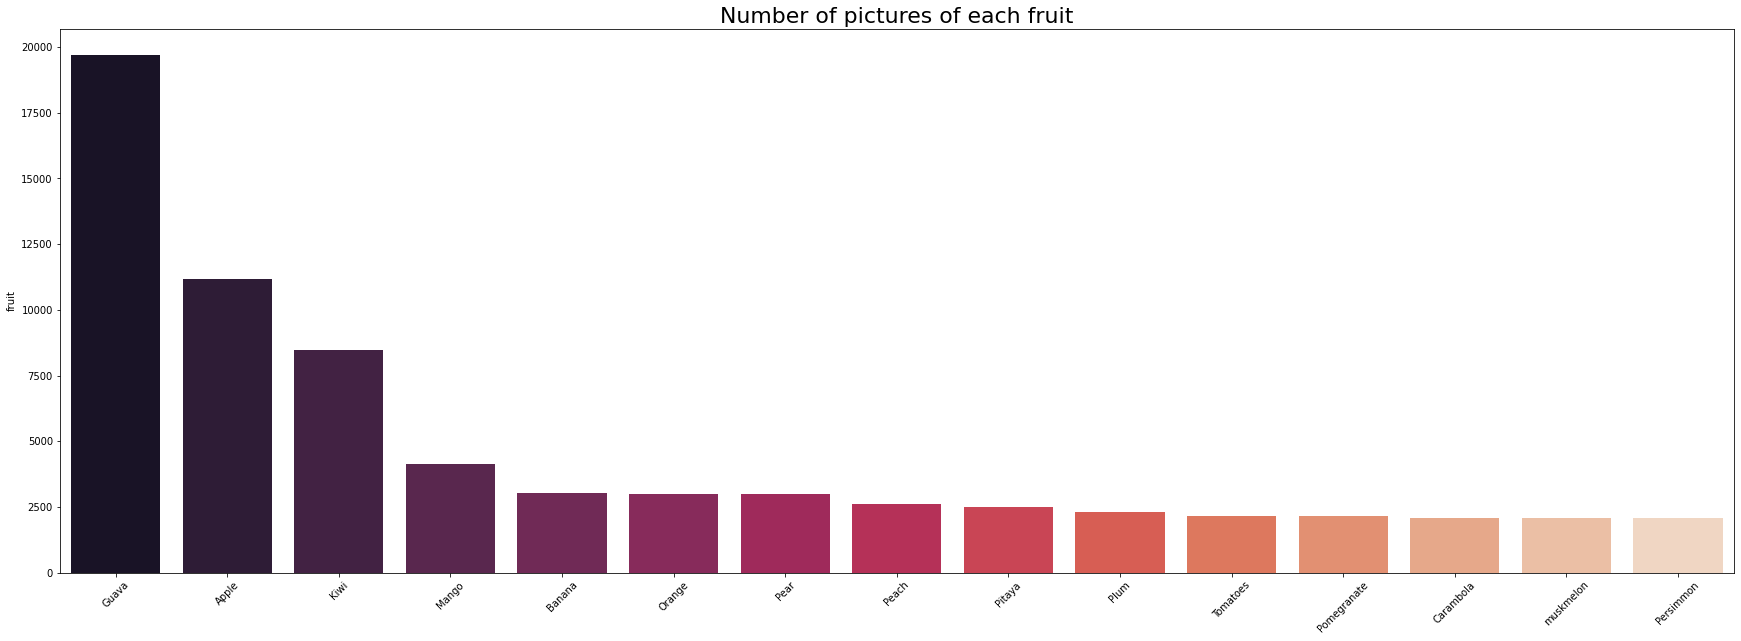

In [6]:
frequency = dataframe["fruit"].value_counts()
plt.figure(figsize=(30,10))
sns.barplot(x = frequency.index, y = frequency, palette = "rocket")
plt.title("Number of pictures of each fruit", fontsize = 22)
plt.xticks(rotation=45)
plt.show()

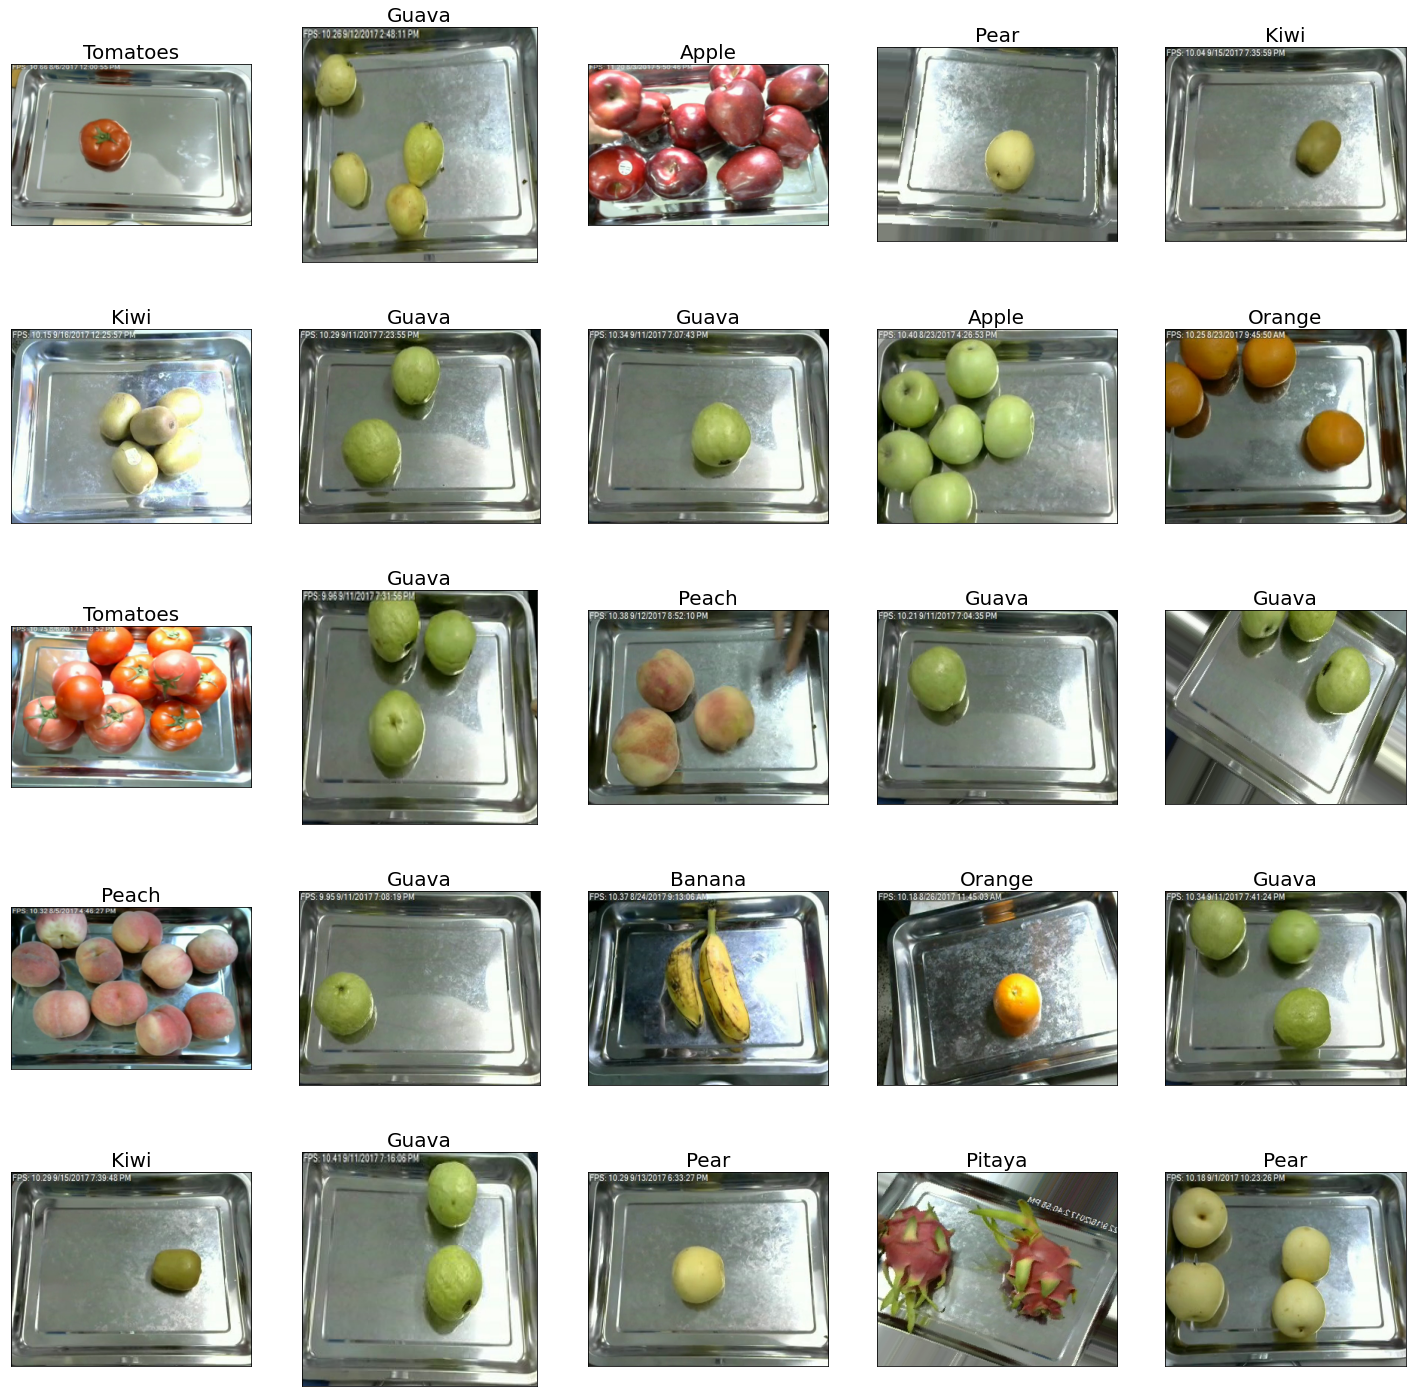

In [7]:
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(25, 25),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(dataframe.path[i+20]))
    ax.set_title(dataframe.fruit[i+20], fontsize = 20)
plt.show()

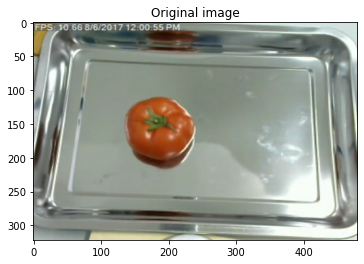

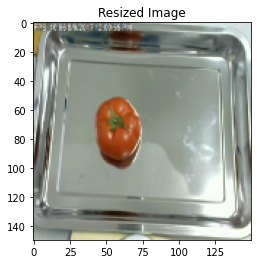

In [8]:
image = plt.imread(dataframe.path[20])
plt.imshow(image)
plt.title("Original image")
plt.show()

plt.imshow(cv2.resize(image, (150,150)))
plt.title("Resized Image")
plt.show()

In [9]:
def reduce_dataframe(dataframe, number_of_parts, part):

    if part < 1:
        print("Error!, the part should be 1 or more")
    elif part > number_of_parts:
        print("Error!, cannot be higher than the number_of_parts")
        
    images_in_part = int(dataframe.shape[0]/number_of_parts)
    idx1 = (part-1) * images_in_part
    idx2 = part * images_in_part
    return dataframe.iloc[idx1:idx2]

def render_image(dataframe):

    img_paths = dataframe["path"].values
    img_labels = dataframe["label"].values
    X = []
    y = []
    
    for i,path in enumerate(img_paths):
        img =  plt.imread(path)
        img = cv2.resize(img, (150,150))
        label = img_labels[i]
        X.append(img)
        y.append(label)
    return np.array(X),np.array(y)

In [10]:
def creating_model():
    image_shape = (150,150,3)
    
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=image_shape, activation='relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(len(map_names)))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    
    return model

In [11]:
def from_categorical(lst):
    
    lst = lst.tolist()
    lst2 = []
    for x in lst:
        lst2.append(x.index(max(x)))
    return lst2

def display_stats(y_test, pred):
    print(f"### Result of the predictions using {len(y_test)} test data ###\n")
    y_test_class = from_categorical(y_test)
    print("Classification Report:\n")
    print(classification_report(y_test_class, pred))
    print("\nConfusion Matrix:\n\n")
    print(confusion_matrix(y_test_class, pred))
    print("\n")
    printout(f"# Accuracy: {round(accuracy_score(y_test_class, pred),5)}")
    
def plot_training(model):
    history = pd.DataFrame(model.history.history)
    history[["accuracy","val_accuracy"]].plot()
    plt.title("Training results")
    plt.xlabel("# epoch")
    plt.show()

In [12]:
model = creating_model()
hists = []

divisor = 5

start_time = time.time()
X_train, y_train = render_image(reduce_dataframe(dataframe,divisor,1))
y_train = to_categorical(y_train)

callbacks = [EarlyStopping(monitor='val_loss', patience=20),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

model.fit(X_train, y_train, batch_size=128, epochs=30, callbacks=callbacks, validation_split = 0.1, verbose = 1)
hists.append(model.history.history)

Epoch 1/30
100/100 [==============================] - 15s 65ms/step - loss: 2.3498 - accuracy: 0.2845 - val_loss: 1.9974 - val_accuracy: 0.3593
Epoch 2/30
100/100 [==============================] - 6s 63ms/step - loss: 1.8527 - accuracy: 0.3957 - val_loss: 2.1241 - val_accuracy: 0.3898
Epoch 3/30
100/100 [==============================] - 6s 58ms/step - loss: 1.4098 - accuracy: 0.5338 - val_loss: 0.8646 - val_accuracy: 0.6818
Epoch 4/30
100/100 [==============================] - 6s 60ms/step - loss: 0.9679 - accuracy: 0.6703 - val_loss: 0.7333 - val_accuracy: 0.7208
Epoch 5/30
100/100 [==============================] - 6s 60ms/step - loss: 0.6621 - accuracy: 0.7665 - val_loss: 0.6188 - val_accuracy: 0.7576
Epoch 6/30
100/100 [==============================] - 6s 59ms/step - loss: 0.4845 - accuracy: 0.8234 - val_loss: 0.3883 - val_accuracy: 0.8583
Epoch 7/30
100/100 [==============================] - 6s 63ms/step - loss: 0.3577 - accuracy: 0.8707 - val_loss: 0.3142 - val_accuracy: 0.887

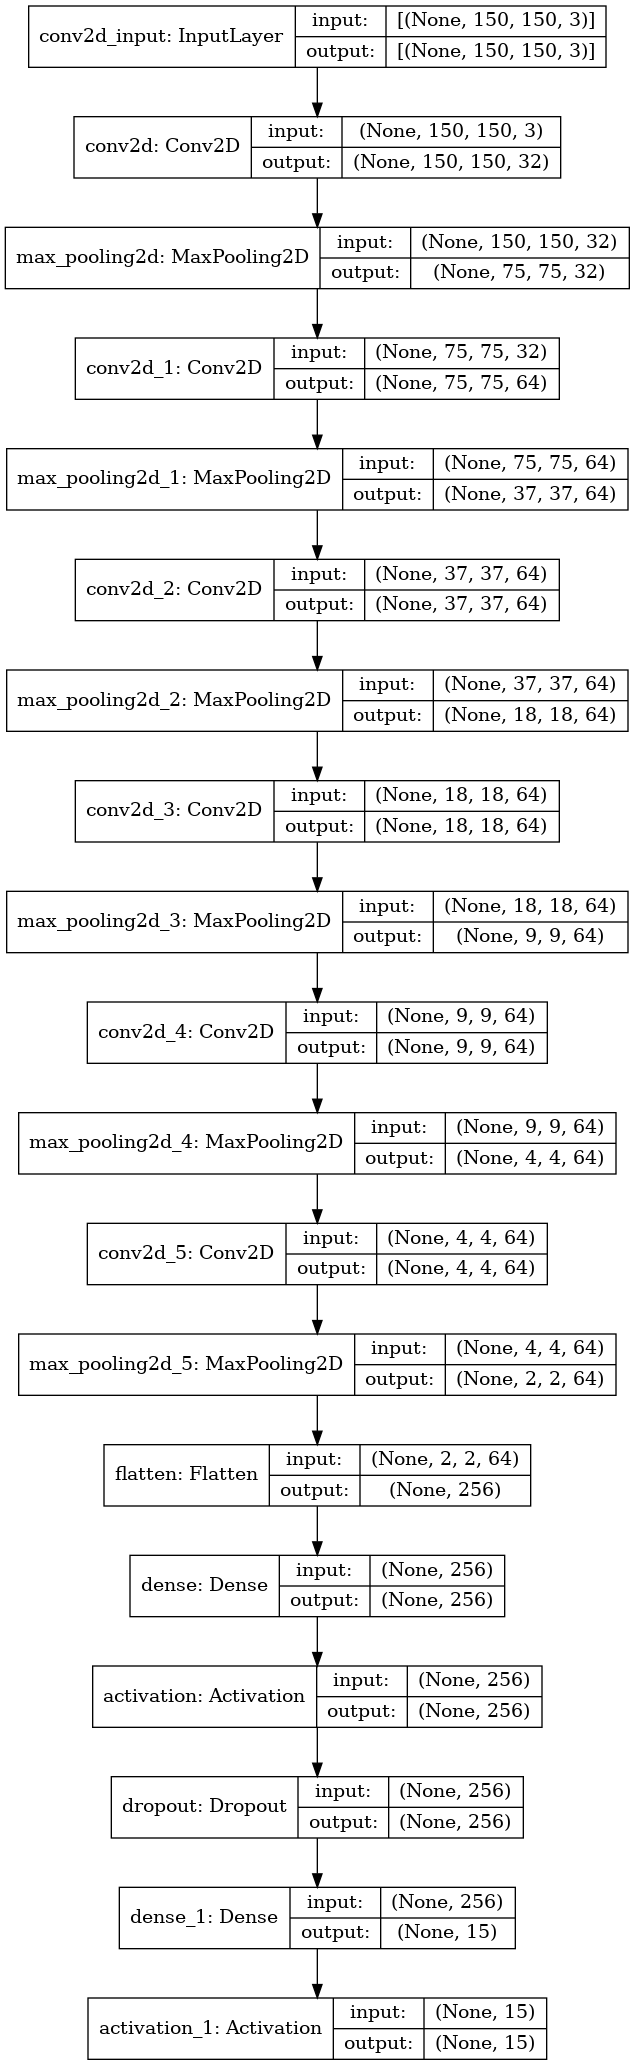

In [20]:
tf.keras.utils.plot_model(model, show_shapes=True,)

In [13]:
gc.collect()

13517

In [14]:
time_model = time.time() - start_time
print(f"Time to train the model: {int(time_model)} seconds")

Time to train the model: 337 seconds


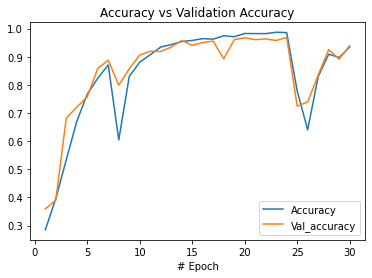

In [15]:
acc = []
val_acc = []
for i in range(len(hists)):
    acc += hists[i]["accuracy"]
    val_acc += hists[i]["val_accuracy"]
hist_df = pd.DataFrame({"# Epoch": [e for e in range(1,len(acc)+1)],"Accuracy": acc, "Val_accuracy": val_acc})
hist_df.plot(x = "# Epoch", y = ["Accuracy","Val_accuracy"])
plt.title("Accuracy vs Validation Accuracy")
plt.show()

In [18]:
import warnings
warnings.filterwarnings("ignore")

X, y = render_image(reduce_dataframe(dataframe, 20, 20))
#pred = model.predict_classes(X)
pred = np.argmax(model.predict(X), axis=1)
y_test = to_categorical(y)

display_stats(y_test, pred)

### Result of the predictions using 3527 test data ###

Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.95      0.91       545
           1       0.82      0.78      0.80       129
           2       0.98      0.93      0.95       109
           3       1.00      0.98      0.99      1027
           4       0.98      0.98      0.98       395
           5       0.93      0.90      0.91       210
           6       0.97      0.97      0.97       151
           7       0.91      0.91      0.91       127
           8       0.82      0.89      0.85       131
           9       0.97      0.98      0.98       104
          10       0.98      0.90      0.94       131
          11       0.97      1.00      0.99       107
          12       0.97      0.94      0.95       129
          13       0.94      0.91      0.92       129
          14       0.83      0.74      0.78       103

    accuracy                           0.94      3527


# Accuracy: 0.94159

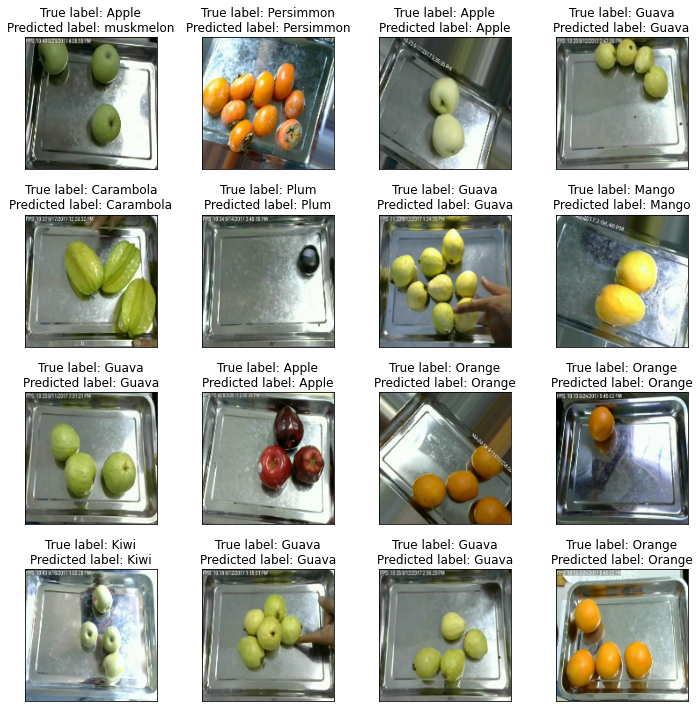

In [19]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(X[-i])
    ax.set_title(f"True label: {fruit_names[y[-i]]}\nPredicted label: {fruit_names[pred[-i]]}")

plt.tight_layout()
plt.show()